# TRABAJO PRÁCTICO Nº 6

**Alumnos:**
- Nahuel Arrieta
- Lucas moyano

In [3]:
import sys
from skimage import io, color, measure
from skimage.color import label2rgb
from skimage.morphology import closing, square
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def read_image(image_name):
    image_path = "./images/" + image_name

    # Read the image
    image = io.imread(image_path)   
    return image

In [5]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

## Sección 1: Representaci´on y Descripci´on de Caracter´ısticas

### 2. (*) Representaci´on por relleno de regiones. Identificar los objetos en una imagen binaria y colorear cada regi´on detectada. Sugerencia: scikit-image: measure.label, regionprops, label2rgb.

In [6]:
## Apply the Otsu thresholding method
def apply_otsu_threshold(image):
    # Convert to grayscale if the image is RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Apply Otsu's threshold
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    return binary



In [11]:
def plot_regions(binary_image, colored_regions):
    """Muestra la imagen binaria original y las regiones coloreadas."""
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Imagen Binaria")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colored_regions)
    plt.title("Regiones Coloreadas")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

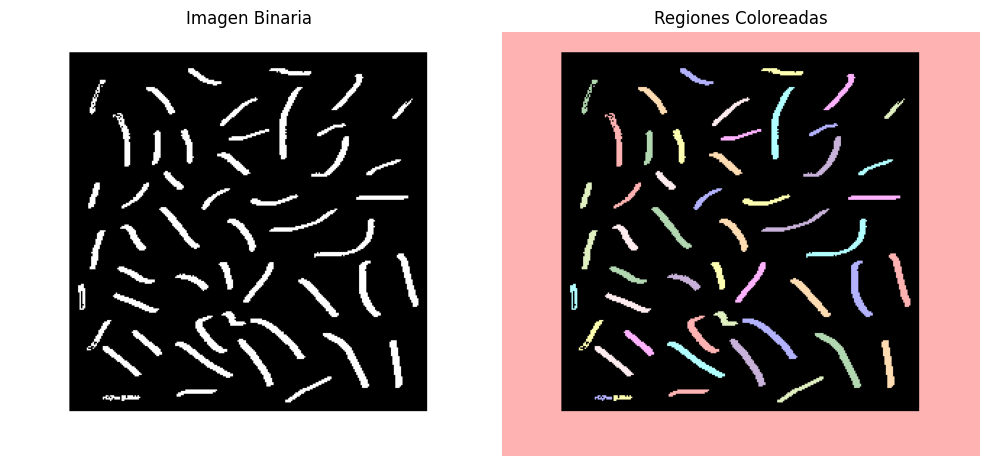

In [15]:
image = read_image("binary.png")
binary_image = apply_otsu_threshold(image)
label_image = measure.label(binary_image)
colored = label2rgb(label_image, image=binary_image, bg_label=0)
plot_regions(binary_image, colored)


### 4. (*) C´alculo de propiedades geom´etricas. Extraer ´area, per´ımetro, excentricidad y compacidad de cada regi´on segmentada. Sugerencia: regionprops de skimage.measure.

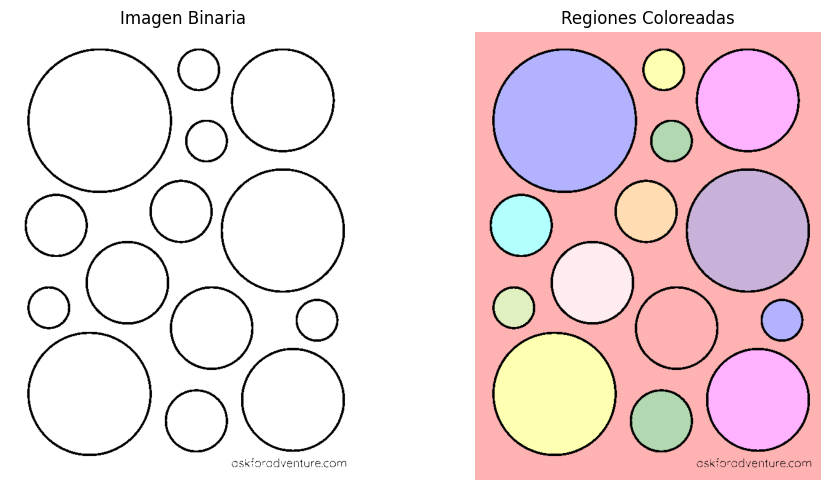

Región 1: Área=187418.0, Perímetro=9535.681092190353, Eccentricidad=0.64, Compacidad=485.17
Región 2: Área=40881.0, Perímetro=753.3523804664972, Eccentricidad=0.03, Compacidad=13.88
Región 3: Área=3067.0, Perímetro=203.8233764908628, Eccentricidad=0.09, Compacidad=13.55
Región 4: Área=20596.0, Perímetro=533.8721497261419, Eccentricidad=0.04, Compacidad=13.84
Región 5: Área=3066.0, Perímetro=203.8233764908628, Eccentricidad=0.09, Compacidad=13.55
Región 6: Área=29861.0, Perímetro=643.0264786586926, Eccentricidad=0.05, Compacidad=13.85
Región 7: Área=7182.0, Perímetro=314.14927829866735, Eccentricidad=0.07, Compacidad=13.74
Región 8: Área=7181.0, Perímetro=314.3919189857867, Eccentricidad=0.05, Compacidad=13.76
Región 9: Área=13007.0, Perímetro=422.47518010647184, Eccentricidad=0.03, Compacidad=13.72
Región 10: Área=3065.0, Perímetro=205.23759005323595, Eccentricidad=0.07, Compacidad=13.74
Región 11: Área=13017.0, Perímetro=424.71782079359116, Eccentricidad=0.04, Compacidad=13.86
Región 

In [21]:
image = read_image("circles.png")
binary_image = apply_otsu_threshold(image)
label_image = measure.label(binary_image)
colored = label2rgb(label_image, image=binary_image, bg_label=0)
plot_regions(binary_image, colored)

props = measure.regionprops(label_image)
for prop in props:
    area = prop.area
    perimeter = prop.perimeter
    eccentricity = prop.eccentricity
    compactness = (perimeter ** 2) / area if area > 0 else 0    
    
    print(f"Región {prop.label}: Área={area}, Perímetro={perimeter}, Eccentricidad={eccentricity:.2f}, Compacidad={compactness:.2f}")
